### 1. Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score

### 2. Loading data

In [2]:
df = pd.read_csv("/kaggle/input/facebook-recruiting-iii-keyword-extraction/Train.zip")
df.head()

,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents


In [3]:
print("Dataframe shape : ", df.shape)

Dataframe shape :  (6034195, 4)


In [4]:
df = df.iloc[:49412, :]
print("Shape of Dataframe after subsetting : ", df.shape)

Shape of Dataframe after subsetting :  (49412, 4)


### 3. Data preprocessing

#### 3.1 Checking for duplicates

In [5]:
duplicate_pairs = df.sort_values('Title', ascending=False).duplicated('Title')
print("Total number of duplicate questions : ", duplicate_pairs.sum())
# passing NOT of duplicate_pairs to see unique values only
df = df[~duplicate_pairs]
print("Dataframe shape after duplicate removal : ", df.shape)

Total number of duplicate questions :  152
Dataframe shape after duplicate removal :  (49260, 4)


In [6]:
df["tag_count"] = df["Tags"].apply(lambda x : len(x.split()))

### 4. Basic Data Analysis on Tags 

#### 4.1. Frequency of tag_count

In [7]:
df["tag_count"].value_counts()

3    14258
2    13075
4     9427
1     6736
5     5764
Name: tag_count, dtype: int64

In [8]:
print( "Maximum number of tags in a question: ", df["tag_count"].max())
print( "Minimum number of tags in a question: ", df["tag_count"].min())
print( "Average number of tags in a question: ", df["tag_count"].mean())

Maximum number of tags in a question:  5
Minimum number of tags in a question:  1
Average number of tags in a question:  2.8864799025578565


Text(0, 0.5, 'Frequency')

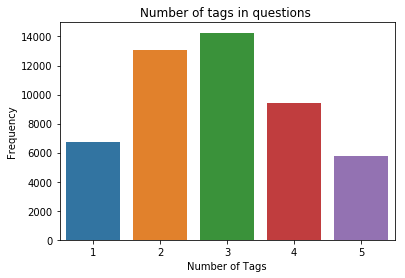

In [9]:
sns.countplot(df["tag_count"])
plt.title("Number of tags in questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Frequency")

**Observations:**

1. Maximum number of tags in a question: 5
2. Minimum number of tags in a question: 1
3. Average number of tags per question: 2.92
4. Most of the questions have either 2 or 3 tags

#### 4.2 Total number of unique tags

In [10]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
tag_bow = vectorizer.fit_transform(df['Tags'])

In [11]:
print("Number of questions :", tag_bow.shape[0])
print("Number of unique tags :", tag_bow.shape[1])

Number of questions : 49260
Number of unique tags : 13821


In [12]:
tags = vectorizer.get_feature_names()
print("Few tags :", tags[:10])

Few tags : ['.class-file', '.each', '.emf', '.hgtags', '.htaccess', '.htpasswd', '.mov', '.net', '.net-1.1', '.net-2.0']


#### 4.3 Frequency of each tag

In [13]:
freq = tag_bow.sum(axis=0).A1
tag_to_count_map = dict(zip(tags, freq))

In [14]:
list = []
for key, value in tag_to_count_map.items():
  list.append([key, value]) 

In [15]:
tag_df = pd.DataFrame(list, columns=['Tags', 'Counts'])
tag_df.tail()

,Tags,Counts
13816,zune,1
13817,zune-hd,1
13818,zurb-foundation,1
13819,zwoptex,1
13820,zxing,4


Text(0, 0.5, 'Frequency')

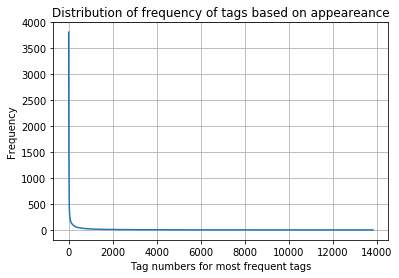

In [16]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
plt.plot(tag_df_sorted['Counts'].values)
plt.grid()
plt.title("Distribution of frequency of tags based on appeareance")
plt.xlabel("Tag numbers for most frequent tags")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

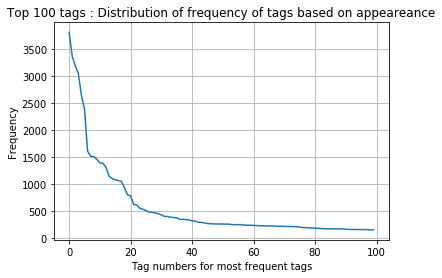

In [17]:
plt.plot(tag_df_sorted['Counts'][0:100].values)
plt.grid()
plt.title("Top 100 tags : Distribution of frequency of tags based on appeareance")
plt.xlabel("Tag numbers for most frequent tags")
plt.ylabel("Frequency")

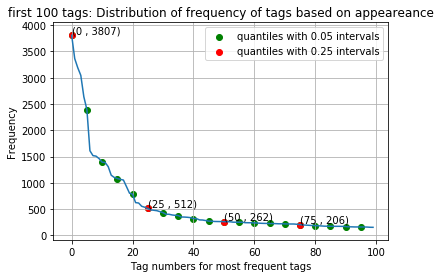

In [18]:
plt.plot(tag_df_sorted['Counts'][0:100].values)
plt.scatter(x=np.arange(0,100,5), y=tag_df_sorted['Counts'][0:100:5], c='g', label="quantiles with 0.05 intervals")
plt.scatter(x=np.arange(0,100,25), y=tag_df_sorted['Counts'][0:100:25], c='r', label = "quantiles with 0.25 intervals")
for x,y in zip(np.arange(0,100,25), tag_df_sorted['Counts'][0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.01, y+30))

plt.title('first 100 tags: Distribution of frequency of tags based on appeareance')
plt.grid()
plt.xlabel("Tag numbers for most frequent tags")
plt.ylabel("Frequency")
plt.legend()

In [19]:
print("{} tags are used more than 25 times".format(tag_df_sorted[tag_df_sorted["Counts"]>25].shape[0]))
print("{} tags are used more than 50 times".format(tag_df_sorted[tag_df_sorted["Counts"]>50].shape[0]))

774 tags are used more than 25 times
380 tags are used more than 50 times


**Observations:**

1. 144 tags are used more than 25 times.
2. 59 tags are used more than 50 times.
3. **C#** is most frequently used tag 778 times.
4. Since some tags occur much more frequenctly than others, Micro-averaged F1-score is the appropriate metric for this probelm.

### 5. Word map for most frequent Tags

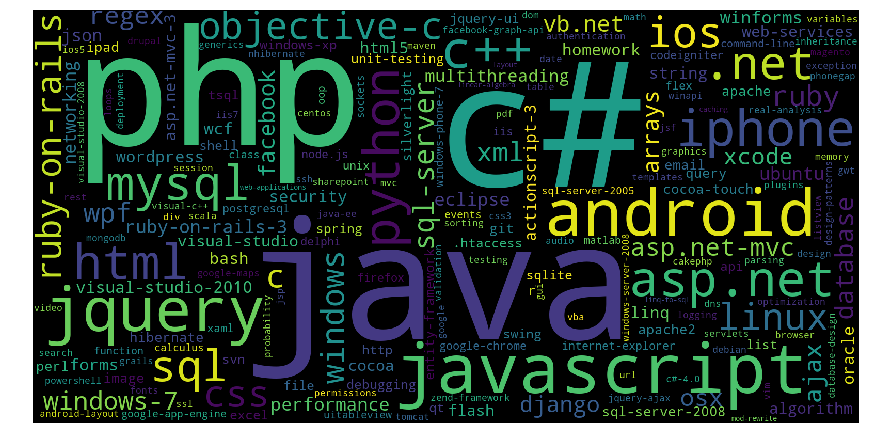

In [20]:
tag_to_count_map
tupl = dict(tag_to_count_map.items())
word_cloud = WordCloud(width=1600,height=800,).generate_from_frequencies(tupl)
plt.figure(figsize = (12,8))
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

**Observations:**

"c#", "java", "php", "android", "javascript", "jquery", "C++" are some of the most frequent tags.

### Bar plot of top 20 tags

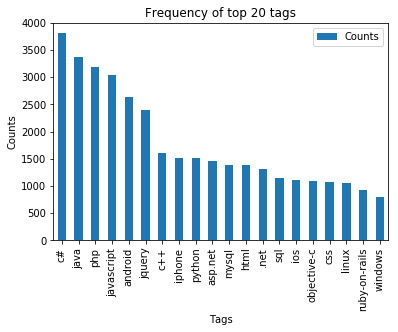

In [21]:
i=np.arange(20)
tag_df_sorted.head(20).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

### 6. Text preprocessing

In [22]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [23]:
qus_list=[]
qus_with_code = 0
len_before_preprocessing = 0 
len_after_preprocessing = 0 
for index,row in df.iterrows():
    title, body, tags = row["Title"], row["Body"], row["Tags"]
    if '<code>' in body:
        qus_with_code+=1
    len_before_preprocessing+=len(title) + len(body)
    body=re.sub('<code>(.*?)</code>', '', body, flags=re.MULTILINE|re.DOTALL)
    body = re.sub('<.*?>', ' ', str(body.encode('utf-8')))
    title=title.encode('utf-8')
    question=str(title)+" "+str(body)
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    qus_list.append(question)
    len_after_preprocessing += len(question)
df["question"] = qus_list
avg_len_before_preprocessing=(len_before_preprocessing*1.0)/df.shape[0]
avg_len_after_preprocessing=(len_after_preprocessing*1.0)/df.shape[0]
print( "Avg. length of questions(Title+Body) before preprocessing: ", avg_len_before_preprocessing)
print( "Avg. length of questions(Title+Body) after preprocessing: ", avg_len_after_preprocessing)
print ("% of questions containing code: ", (qus_with_code*100.0)/df.shape[0])

Avg. length of questions(Title+Body) before preprocessing:  1151.9917377182298
Avg. length of questions(Title+Body) after preprocessing:  328.37168087697927
% of questions containing code:  55.75923670320747


In [24]:
preprocessed_df = df[["question","Tags"]]
print("Shape of preprocessed data :", preprocessed_df.shape)

Shape of preprocessed data : (49260, 2)


## 7. Machine learning models

### 7.1 Multilabel problem - Handling tags

In [25]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
y_multilabel = vectorizer.fit_transform(preprocessed_df['Tags'])

In [26]:
def tags_to_consider(n):
    tag_i_sum = y_multilabel.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(tag_i_sum)), key=lambda i: tag_i_sum[i], reverse=True)
    yn_multilabel=y_multilabel[:,sorted_tags_i[:n]]
    return yn_multilabel

def questions_covered_fn(numb):
    yn_multilabel = tags_to_consider(numb)
    x= yn_multilabel.sum(axis=1)
    return (np.count_nonzero(x==0))

In [27]:
questions_covered = []
total_tags=y_multilabel.shape[1]
total_qus=preprocessed_df.shape[0]
for i in range(100, total_tags, 100):
    questions_covered.append(np.round(((total_qus-questions_covered_fn(i))/total_qus)*100,3))

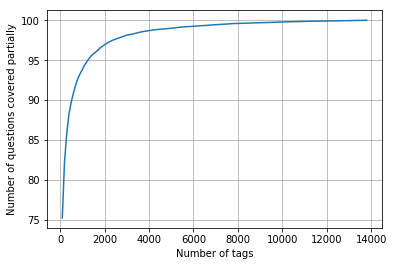

93.819 % of questions covered by 1000 tags
Number of questions that are not covered by 100 tags :  3045 out of  49260


In [28]:
plt.plot(np.arange(100,total_tags, 100),questions_covered)
plt.xlabel("Number of tags")
plt.ylabel("Number of questions covered partially")
plt.grid()
plt.show()
print(questions_covered[9],"% of questions covered by 1000 tags")
print("Number of questions that are not covered by 100 tags : ", questions_covered_fn(1000),"out of ", total_qus)

In [29]:
yx_multilabel = tags_to_consider(1000)
print("Number of tags in the subset :", y_multilabel.shape[1])
print("Number of tags considered :", yx_multilabel.shape[1],"(",(yx_multilabel.shape[1]/y_multilabel.shape[1])*100,"%)")

Number of tags in the subset : 13821
Number of tags considered : 1000 ( 7.235366471311772 %)


### 7.2 Splitting into train and test set with 80:20 ratio

In [30]:
X_train, X_test, y_train, y_test = train_test_split(preprocessed_df, yx_multilabel, test_size = 0.2,random_state = 42)
print("Number of data points in training data :", X_train.shape[0])
print("Number of data points in test data :", X_test.shape[0])

Number of data points in training data : 39408
Number of data points in test data : 9852


###  7.3 Featurization of Training Data

In [31]:
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, tokenizer = lambda x: x.split(), ngram_range=(1,3))
X_train_multilabel = vectorizer.fit_transform(X_train['question'])
X_test_multilabel = vectorizer.transform(X_test['question'])

In [32]:
print("Training data shape X : ",X_train_multilabel.shape, "Y :",y_train.shape)
print("Test data shape X : ",X_test_multilabel.shape,"Y:",y_test.shape)

Training data shape X :  (39408, 104305) Y : (39408, 1000)
Test data shape X :  (9852, 104305) Y: (9852, 1000)


### 7.4 Fitting Logistic Regression with OneVsRest Classifier

In [33]:
clf = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l2'))
clf.fit(X_train_multilabel, y_train)
y_pred = clf.predict(X_test_multilabel)

In [34]:
print("Accuracy :",metrics.accuracy_score(y_test,y_pred))
print("Macro f1 score :",metrics.f1_score(y_test, y_pred, average = 'macro'))
print("Micro f1 scoore :",metrics.f1_score(y_test, y_pred, average = 'micro'))
print("Hamming loss :",metrics.hamming_loss(y_test,y_pred))
#print("Precision recall report :\n",metrics.classification_report(y_test, y_pred))

Accuracy : 0.12768980917580186
Macro f1 score : 0.08488042442324158
Micro f1 scoore : 0.30022661561303426
Hamming loss : 0.001817904993909866


* ### 7.5 Modelling by assigning more weightage to Title

In [35]:
qus_list=[]
qus_with_code = 0
len_before_preprocessing = 0 
len_after_preprocessing = 0 
for index,row in df.iterrows():
    title, body, tags = row["Title"], row["Body"], row["Tags"]
    if '<code>' in body:
        qus_with_code+=1
    len_before_preprocessing+=len(title) + len(body)
    body=re.sub('<code>(.*?)</code>', '', body, flags=re.MULTILINE|re.DOTALL)
    body = re.sub('<.*?>', ' ', str(body.encode('utf-8')))
    title=title.encode('utf-8')
    question=str(title)+" "+str(title)+" "+str(title)+" "+ body
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    qus_list.append(question)
    len_after_preprocessing += len(question)
df["question_with_more_wt_title"] = qus_list
avg_len_before_preprocessing=(len_before_preprocessing*1.0)/df.shape[0]
avg_len_after_preprocessing=(len_after_preprocessing*1.0)/df.shape[0]
print( "Avg. length of questions(Title+Body) before preprocessing: ", avg_len_before_preprocessing)
print( "Avg. length of questions(Title+Body) after preprocessing: ", avg_len_after_preprocessing)
print ("% of questions containing code: ", (qus_with_code*100.0)/df.shape[0])


Avg. length of questions(Title+Body) before preprocessing:  1151.9917377182298
Avg. length of questions(Title+Body) after preprocessing:  399.02612667478684
% of questions containing code:  55.75923670320747


In [36]:
preprocessed_df = df[["question_with_more_wt_title","Tags"]]
print("Shape of preprocessed data :", preprocessed_df.shape)

Shape of preprocessed data : (49260, 2)


In [37]:
X_train, X_test, y_train, y_test = train_test_split(preprocessed_df, yx_multilabel, test_size = 0.2,random_state = 42)
print("Number of data points in training data :", X_train.shape[0])
print("Number of data points in test data :", X_test.shape[0])

Number of data points in training data : 39408
Number of data points in test data : 9852


In [38]:
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, tokenizer = lambda x: x.split(), ngram_range=(1,3))
X_train_multilabel = vectorizer.fit_transform(X_train['question_with_more_wt_title'])
X_test_multilabel = vectorizer.transform(X_test['question_with_more_wt_title'])

In [39]:
print("Training data shape X : ",X_train_multilabel.shape, "Y :",y_train.shape)
print("Test data shape X : ",X_test_multilabel.shape,"Y:",y_test.shape)

Training data shape X :  (39408, 106204) Y : (39408, 1000)
Test data shape X :  (9852, 106204) Y: (9852, 1000)


In [40]:
clf = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l2'))
clf.fit(X_train_multilabel, y_train)
y_pred = clf.predict(X_test_multilabel)

In [41]:
print("Accuracy :",metrics.accuracy_score(y_test,y_pred))
print("Macro f1 score :",metrics.f1_score(y_test, y_pred, average = 'macro'))
print("Micro f1 scoore :",metrics.f1_score(y_test, y_pred, average = 'micro'))
print("Hamming loss :",metrics.hamming_loss(y_test,y_pred))

Accuracy : 0.14342265529841655
Macro f1 score : 0.10975868281411373
Micro f1 scoore : 0.3419602477862653
Hamming loss : 0.0017575111652456353


In [42]:
#using direct implementation of Logistic Regression
clf2 = OneVsRestClassifier(LogisticRegression(penalty='l1'))
clf2.fit(X_train_multilabel, y_train)
y_pred2 = clf2.predict(X_test_multilabel)

In [43]:
print("Accuracy :",metrics.accuracy_score(y_test,y_pred2))
print("Macro f1 score :",metrics.f1_score(y_test, y_pred2, average = 'macro'))
print("Micro f1 scoore :",metrics.f1_score(y_test, y_pred2, average = 'micro'))
print("Hamming loss :",metrics.hamming_loss(y_test,y_pred2))

Accuracy : 0.163723101908242
Macro f1 score : 0.2688583862591395
Micro f1 scoore : 0.4311207246180885
Hamming loss : 0.001708485586682907


In [45]:
pred=clf2.predict(X_test_multilabel)